In [2]:
#Importing Packages
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score


In [3]:
#Getting the data
phishing_data = pd.read_csv('cleaned-outliers.csv')
phishing_data.head()


,NoOfImage,NoOfSelfRef,LineOfCode,NoOfExternalRef,label
0,0.003796,0.004344,0.001256,0.004506,1
1,0.005583,0.001424,0.001392,0.007886,1
2,0.001117,0.001533,0.001050,0.000182,1
3,0.000335,0.000803,0.014354,0.001127,1
4,0.027244,0.002628,0.013751,0.003089,1


In [6]:
# Features and target
features = ['NoOfImage', 'NoOfSelfRef', 'LineOfCode', 'NoOfExternalRef']
target = 'label'

In [8]:
# Define the model and hyperparameter grid
nb_model = GaussianNB()
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}


#Getting the parameters
params = nb_model.get_params()
# Print the parameters
for param, value in params.items():
    print(f"{param}: {value}")

priors: None
var_smoothing: 1e-09


In [10]:
# Split the data into features (X) and target (y)
X = phishing_data[features]
y = phishing_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.model_selection import GridSearchCV

# Since the dataset is already normalized, directly use X
X_normalized = X  # No additional scaling needed

# Perform hyperparameter tuning with cross-validation
nb_model = GaussianNB()
grid_search = GridSearchCV(nb_model, param_grid,scoring='accuracy')
grid_search.fit(X_normalized, y)

# Retrieve the best model and parameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Best Hyperparameters: {'var_smoothing': 1e-08}
Best Cross-Validated Accuracy: 0.9637269662206578


In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results for each fold
testaccuracies = []
testconfusion_matrices = []
testclassification_reports = []

trainaccuracies = []
trainconfusion_matrices = []
trainclassification_reports = []

# Stratified K-Fold Cross-Validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Use the best model found by GridSearchCV, train the model
    best_nb = grid_search.best_estimator_
    best_nb.fit(X_train, y_train)

    # Make predictions
    nb_predictionstrain = best_nb.predict(X_train)
    nb_predictionstest = best_nb.predict(X_test)

    # Evaluate the model for the current fold
    testaccuracies.append(best_nb.score(X_test, y_test))  # Accuracy
    testconfusion_matrices.append(confusion_matrix(y_test, nb_predictionstest))
    testclassification_reports.append(classification_report(y_test, nb_predictionstest, output_dict=True))

    trainaccuracies.append(best_nb.score(X_train, y_train))  # Accuracy
    trainconfusion_matrices.append(confusion_matrix(y_train, nb_predictionstrain))
    trainclassification_reports.append(classification_report(y_train, nb_predictionstrain, output_dict=True))

# Print the mean accuracy
print(f"(Testing) Mean Accuracy: {np.mean(testaccuracies):.4f}")
print(f"(Training) Mean Accuracy: {np.mean(trainaccuracies):.4f}")

# Print the mean confusion matrix
test_mean_confusion_matrix = np.mean(testconfusion_matrices, axis=0)
print(f"(Testing) Mean Confusion Matrix: \n{test_mean_confusion_matrix}")

train_mean_confusion_matrix = np.mean(trainconfusion_matrices, axis=0)
print(f"(Training) Mean Confusion Matrix: \n{train_mean_confusion_matrix}")

# Compute average classification report for Class 0
testavg_precision_0 = np.mean([report['0']['precision'] for report in testclassification_reports])
testavg_recall_0 = np.mean([report['0']['recall'] for report in testclassification_reports])
testavg_f1_0 = np.mean([report['0']['f1-score'] for report in testclassification_reports])

trainavg_precision_0 = np.mean([report['0']['precision'] for report in trainclassification_reports])
trainavg_recall_0 = np.mean([report['0']['recall'] for report in trainclassification_reports])
trainavg_f1_0 = np.mean([report['0']['f1-score'] for report in trainclassification_reports])

# Average Classification Report for Class 0
print(f"\nAverage Classification Report (Class 0 Testing):")
print(f"Precision: {testavg_precision_0:.4f}")
print(f"Recall: {testavg_recall_0:.4f}")
print(f"F1-Score: {testavg_f1_0:.4f}")

print(f"\nAverage Classification Report (Class 0 Training):")
print(f"Precision: {trainavg_precision_0:.4f}")
print(f"Recall: {trainavg_recall_0:.4f}")
print(f"F1-Score: {trainavg_f1_0:.4f}")

# Compute average classification report for Class 1
testavg_precision = np.mean([report['1']['precision'] for report in testclassification_reports])
testavg_recall = np.mean([report['1']['recall'] for report in testclassification_reports])
testavg_f1 = np.mean([report['1']['f1-score'] for report in testclassification_reports])

trainavg_precision = np.mean([report['1']['precision'] for report in trainclassification_reports])
trainavg_recall = np.mean([report['1']['recall'] for report in trainclassification_reports])
trainavg_f1 = np.mean([report['1']['f1-score'] for report in trainclassification_reports])

# Average Classification Report for Class 1
print(f"\nAverage Classification Report (Class 1 Testing):")
print(f"Precision: {testavg_precision:.4f}")
print(f"Recall: {testavg_recall:.4f}")
print(f"F1-Score: {testavg_f1:.4f}")

print(f"\nAverage Classification Report (Class 1 Training):")
print(f"Precision: {trainavg_precision:.4f}")
print(f"Recall: {trainavg_recall:.4f}")
print(f"F1-Score: {trainavg_f1:.4f}")

# Optionally, print the full classification report for each fold
print(f"\nFull Classification Report (averaged test):")
for i in range(len(testclassification_reports)):
    print(f"Fold {i+1}:\n{testclassification_reports[i]}")

print(f"\nFull Classification Report (averaged training):")
for i in range(len(trainclassification_reports)):
    print(f"Fold {i+1}:\n{trainclassification_reports[i]}")

(Testing) Mean Accuracy: 0.9625
(Training) Mean Accuracy: 0.9626
(Testing) Mean Confusion Matrix: 
[[19561.4   627.6]
 [ 1138.6 25831.4]]
(Training) Mean Confusion Matrix: 
[[ 78247.    2509. ]
 [  4553.4 103326.6]]

Average Classification Report (Class 0 Testing):
Precision: 0.9450
Recall: 0.9689
F1-Score: 0.9568

Average Classification Report (Class 0 Training):
Precision: 0.9450
Recall: 0.9689
F1-Score: 0.9568

Average Classification Report (Class 1 Testing):
Precision: 0.9763
Recall: 0.9578
F1-Score: 0.9669

Average Classification Report (Class 1 Training):
Precision: 0.9763
Recall: 0.9578
F1-Score: 0.9670

Full Classification Report (averaged test):
Fold 1:
{'0': {'precision': 0.9472459270752521, 'recall': 0.9676556540690475, 'f1-score': 0.957342023374905, 'support': 20189.0}, '1': {'precision': 0.9753909930280761, 'recall': 0.9596588802373007, 'f1-score': 0.9674609849546771, 'support': 26970.0}, 'accuracy': 0.9630823384719778, 'macro avg': {'precision': 0.9613184600516641, 'recal

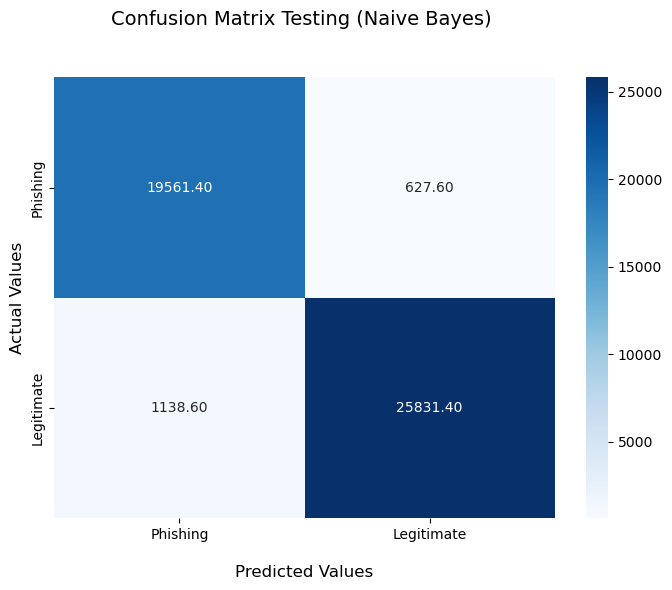

In [27]:
fig, ax = plt.subplots(figsize=(7, 6))  # Increase figure size

# Create the heatmap
ax = sns.heatmap(test_mean_confusion_matrix, annot=True, cmap='Blues', fmt='.2f')

# Add titles and labels
ax.set_title('Confusion Matrix Testing (Naive Bayes) \n\n', fontsize=14)
ax.set_xlabel('\nPredicted Values', fontsize=12)
ax.set_ylabel('Actual Values', fontsize=12)

# Adjust tick labels to be descriptive
ax.xaxis.set_ticklabels(['Phishing', 'Legitimate'], fontsize=10)
ax.yaxis.set_ticklabels(['Phishing', 'Legitimate'], fontsize=10)

# Use tight layout for spacing
plt.tight_layout()

# Display the visualization
plt.show()


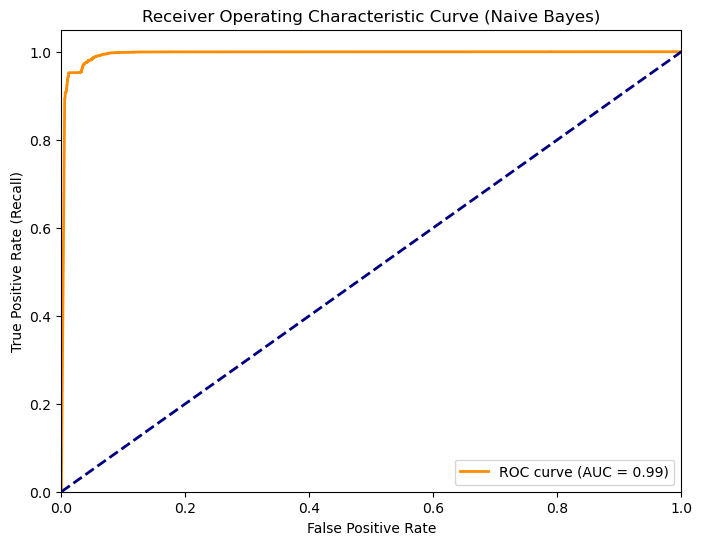

In [15]:
from sklearn.metrics import roc_curve, auc
# Predict probabilities for ROC curve
y_prob_test = best_nb.predict_proba(X_test)[:, 1]  # Only take probabilities for class 1

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic Curve (Naive Bayes)')
plt.legend(loc="lower right")
plt.show()

In [16]:
'''#Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

nb_predictions = nb_model.predict(X_test)

print("Naive Bayes Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, nb_predictions)}")
print(classification_report(y_test, nb_predictions))'''

'#Naive Bayes Classifier\nnb_model = GaussianNB()\nnb_model.fit(X_train, y_train)\n\nnb_predictions = nb_model.predict(X_test)\n\nprint("Naive Bayes Classifier Results:")\nprint(f"Accuracy: {accuracy_score(y_test, nb_predictions)}")\nprint(classification_report(y_test, nb_predictions))'